# Svensson (1994)



$$ r(t) = \beta_1 + \beta_2\frac{1-e^{-\lambda_1 t}}{\lambda_1 t} 
        + \beta_3 \left(\frac{1-e^{-\lambda_1 t}}{\lambda_1 t}-e^{-\lambda_1 t}\right)
        + \beta_4 \left(\frac{1-e^{-\lambda_2 t}}{\lambda_2 t}-e^{-\lambda_2 t}\right)$$

### Importing the data

In [510]:
from scipy.optimize import fmin
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
from bizdays import Calendar

path = r"C:\Users\Alysson\Documents\GitHub\Monetary-Shocks\Brasil\ETTJ\Titulos.xlsx"
path2 = r"C:\Users\Alysson\Documents\GitHub\Monetary-Shocks\Brasil\ETTJ\Parametros.xlsx"
df = pd.read_excel(path)
parameters = pd.read_excel(path2)

### Coupon Calculation


In [511]:
cal = Calendar.load("ANBIMA")
parameters.set_index("Data referência", inplace=True)

### Coupon Calculation

df["Coupon"] = df["CODIGO"].apply(lambda x: 10 if x == "NTN-F" else 0)
df['DATA_VENCIMENTO'] = pd.to_datetime(df['DATA_VENCIMENTO'])

# Function to calculate the number of days between two dates
def calculate_days_between_dates(reference_date, coupon_date):
    return (coupon_date - reference_date).days

# Function to generate the number of coupon days between two dates
def calculate_coupon_days(reference_date, maturity_date):
    first_january = pd.Timestamp(reference_date).replace(month=1, day=1)
    first_july = pd.Timestamp(reference_date).replace(month=7, day=1)
    
    coupon_dates = [first_january, first_july]
    
    next_january = first_january + pd.DateOffset(years=1)
    next_july = first_july + pd.DateOffset(years=1)
    
    while next_january <= maturity_date:
        coupon_dates.append(next_january)
        coupon_dates.append(next_july)
        next_january = next_january + pd.DateOffset(years=1)
        next_july = next_july + pd.DateOffset(years=1)
    
    coupon_days = [calculate_days_between_dates(reference_date, coupon_date) for coupon_date in coupon_dates if coupon_date >= reference_date and coupon_date <= maturity_date]
    return coupon_days

# Fill the 'Coupon_Days' column with 0 for all values in 'CODE' column that are not equal to "NTN-F"
df.loc[df["CODIGO"] != "NTN-F", "Coupon_Days"] = 0
# Fill the column with the number of days using apply only for values in 'CODE' column that are equal to "NTN-F"
df.loc[df["CODIGO"] == "NTN-F", 'Coupon_Days'] = df[df["CODIGO"] == "NTN-F"].apply(lambda row: calculate_coupon_days(row['DATA_REFERENCIA'], row['DATA_VENCIMENTO']), axis=1)


In [513]:
### CDI treatments

#CDI.rename(columns={'Data': 'DATA_REFERENCIA'}, inplace=True)
#CDI.rename(columns={'CDI': 'EXPECTATIVA'}, inplace=True)
#CDI["CODIGO"]="CDI"
#CDI["DATA_VENCIMENTO"]=cal.offset(CDI["DATA_REFERENCIA"],1)
#CDI["PU"]=1000/((1+CDI['EXPECTATIVA'])**(1/252))
#CDI = CDI[["CODIGO",'DATA_REFERENCIA',"DATA_VENCIMENTO",'EXPECTATIVA',"PU"]]

### Maturity Calculation

#df = pd.concat([df, CDI], ignore_index=True)
df["Maturity"] = np.array(cal.bizdays(df["DATA_REFERENCIA"], df["DATA_VENCIMENTO"]))/252
df.set_index("DATA_REFERENCIA", inplace=True)
df = df[df['Maturity'] >= 1]
df.sort_index()

### Duration Calculation



C:\Users\Alysson\AppData\Local\Temp\ipykernel_11876\1996319278.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Macaulay_duration"] = ((1+yld) / (m*yld)) - ( (1 + yld + n*(cpn-yld)) / ((m*cpn* ((1+yld)**n - 1)) + m*yld) )


In [514]:
df.head()

,CODIGO,DATA_VENCIMENTO,EXPECTATIVA,PU,Coupon,Coupon_Days,Maturity,Macaulay_duration
DATA_REFERENCIA,,,,,,,,
2023-07-03,LTN,2024-10-01,11.0232,877.471104,0,0.0,1.250000,1.250000
2023-07-03,LTN,2025-01-01,10.6656,858.630640,0,0.0,1.500000,1.500000
2023-07-03,LTN,2025-04-01,10.4497,840.685083,0,0.0,1.746032,1.746032
2023-07-03,LTN,2025-07-01,10.2747,823.292000,0,0.0,1.988095,1.988095
2023-07-03,LTN,2026-01-01,10.0743,786.057522,0,0.0,2.503968,2.503968
...,...,...,...,...,...,...,...,...
2023-08-02,NTN-F,2025-01-01,10.7753,998.588004,10,"[152, 334, 518]",1.412698,1.060102
2023-08-02,NTN-F,2027-01-01,10.1920,1003.263292,10,"[152, 334, 518, 699, 883, 1064, 1248]",3.408730,1.097836
2023-08-02,NTN-F,2029-01-01,10.5220,989.244392,10,"[152, 334, 518, 699, 883, 1064, 1248, 1429, 16...",5.392857,1.095037



### Generating individuals

In [304]:
N =1200             ### Number of individuals 
p = int(2/3*N)      ### Proportion of individuals generated by method 1
var = 0.25           ### variance normal distribution

### 1 - Initial Values of the results of the estimation of the previous day

ref_date_str = "2023-07-27"
ref_date = datetime.strptime(ref_date_str, "%Y-%m-%d")
previous_date = cal.offset(ref_date_str,-1)
previous_parameters = parameters.loc[str(previous_date)][1:]
beta_star_1 = np.array([previous_parameters.replace(previous_parameters[1],previous_parameters[0])])
e_previous = beta_star_1.T*np.random.normal(0, var, size=(6, p))
beta_previous = beta_star_1.T + e_previous

### 2 - Approximation that takes into account the observed yield to maturity (ytm)

data_estimada = df.loc[ref_date_str]
data_estimada=data_estimada.sort_values("Maturity")
b1 = data_estimada["EXPECTATIVA"][0]/100
b2 = data_estimada["EXPECTATIVA"][-1]/100 - data_estimada["EXPECTATIVA"][0]/100
b3 = 0
b4 = 0
lbda1 = previous_parameters[4]
lbda2 = previous_parameters[5]
#lbda1 = (data_estimada["Maturity"][-1]-data_estimada["Maturity"][0])/2
#lbda2 = lbda1
beta_star_2 = np.array([b1, b2, b3 , b4, lbda1, lbda2])[:, np.newaxis]
e_approx = beta_star_2*np.random.normal(0, var, size=(6, N-p))
beta_approx = beta_star_2 + e_approx ## ajustar colunas

### Adding constraints to the parameters

def update (betas,beta_star):
    updated_value = []
    for index, parameter in enumerate(betas):
        if parameter[0]<0:
            betas[index][0] = beta_star[0]+ beta_star[0]*np.random.normal(0, var)
            updated_value.append(betas[index][0]<0)
        if (parameter[0]+parameter[1])<0:
            betas[index][1] = beta_star[1]+ beta_star[1]*np.random.normal(0, var)
            updated_value.append((betas[index][0]+betas[index][1])<0)
        if parameter[4]<0:
            betas[index][4] = beta_star[4]+ beta_star[4]*np.random.normal(0, var)
            updated_value.append(betas[index][4]<0)
        if parameter[5]<0:
            betas[index][5] = beta_star[5]+ beta_star[5]*np.random.normal(0, var)
            updated_value.append(betas[index][5]<0)
    if sum(updated_value) != 0:
        update(betas,beta_star)
    return(beta_previous.T)

update(beta_previous.T,beta_star_1.T)
update(beta_approx,beta_star_2)

individuals = np.concatenate((beta_previous.T, beta_approx.T), axis=0)

### Selection

In [306]:
alpha = 6
var = 0.25
pi = 0.35
### 40% of the individuals survive
s = int(0.4 * N)

def myval(c):
    nss =(c[0])+(c[1]*((1-np.exp(-df['Maturity']*c[4]))/(df['Maturity']*c[4])))+(c[2]*((((1-np.exp(-df['Maturity']*c[4]))/(df['Maturity']*c[4])))-(np.exp(-df['Maturity']*c[4]))))+(c[3]*((((1-np.exp(-df['Maturity']*c[5]))/(df['Maturity']*c[5])))-(np.exp(-df['Maturity']*c[5]))))
    Calculated_price  = 1000 / (1 + nss) ** df['Maturity'] 
    df['Residual'] =  ((df['PU'] - Calculated_price)**2)*(1/df["Macaulay_duration"]**0.5)
    val = np.sum(df['Residual'])
    return(val)

for interation in range(10):

    values = []
    
    for row in individuals:    
        val = myval(row)
        values.append((round(val,1), row)) 
    sol = pd.DataFrame(values, columns=['SC', "Parameters"]).sort_values('SC')

    selection = sol.sort_values('SC')[0:s]


    next_gen = []
    e_mutation = []
    new_individuals = []
    
    if interation > 1:
        var = var*1.02

    while len(new_individuals)<N:
        
        psi = np.random.uniform(0, 1)
        theta_r = np.concatenate(selection.iloc[(np.random.beta(1,alpha, 1)*s),:]["Parameters"].values)
        theta_s = np.concatenate(selection.iloc[(np.random.beta(1,alpha, 1)*s),:]["Parameters"].values)
        next_gen.append(psi*theta_r+(1-psi)*theta_s)
        e = np.random.normal(0, var, 6)*np.random.choice([0, 1], size=6, p=[1 - pi, pi])
        e_mutation.append(e)        
        #new_ind = (np.array(next_gen)+np.array(next_gen)*np.array(e_mutation)).flatten() 
        #conditions = [new_ind[0]>0, (new_ind[0]+new_ind[1])>0 , new_ind[4]>0, new_ind[5]>0]
        #if all(conditions):         
        #new_individuals.append(new_ind.tolist())
        new_individuals = np.array(next_gen)+np.array(next_gen)*np.array(e_mutation)
         
    individuals = new_individuals

        
selection.head()

,SC,Parameters
635,312.4,"[0.11131210087839491, 0.03367378751867553, 0.0..."
577,313.8,"[0.11238798910747792, 0.03489562922456517, 0.0..."
37,318.0,"[0.11205977182442241, 0.03515916040526857, 0.0..."
314,318.3,"[0.11166329981010785, 0.034902109016119454, 0...."
1134,318.7,"[0.11164583592083002, 0.03480846266782341, 0.0..."


In [272]:
selection.iloc[(np.random.beta(1,alpha, 1)*s),:]["Parameters"].values

array([array([ 0.11031102,  0.06194832,  0.05029979, -0.08088328,  3.60648734,
               1.37690024])                                                   ],
      dtype=object)

In [274]:
individuals

array([[ 0.14614886,  0.06288971,  0.04221766, -0.04968488,  3.1915174 ,
         1.59896257],
       [ 0.11064635,  0.07328342,  0.03752601, -0.07781479,  3.89158909,
         0.92488109],
       [ 0.10993794,  0.05489933,  0.03841382, -0.07425823,  3.14481483,
         1.3527404 ],
       ...,
       [ 0.11027633,  0.05609518,  0.04903437, -0.07601721,  2.99282461,
         0.98096726],
       [ 0.11095689,  0.02377505,  0.0429298 , -0.08327817,  3.26733883,
         1.44568431],
       [ 0.09382207,  0.05949227,  0.02126772, -0.08078642,  3.19493872,
         1.0766341 ]])

In [183]:
dia27 = selection.iloc[0][1]
dia27_anbima = parameters.iloc[-2,1:].values



Text(0.5, 1.0, '2023-07-27 00:00:00')

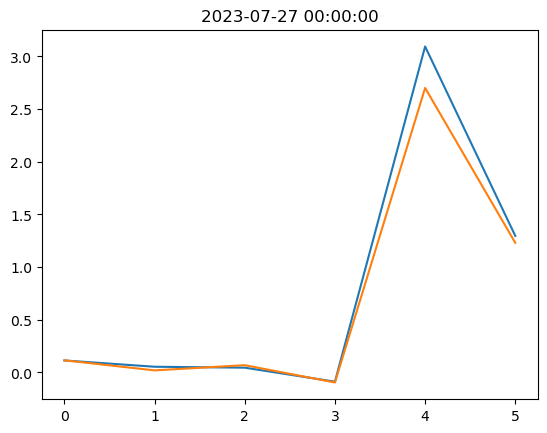

In [184]:
rounded_series = selection["Parameters"].apply(lambda lst: [round(x, 1) for x in lst])
rounded_series[0:99]
plt.plot(dia27)
plt.plot(dia27_anbima)
plt.title(f'{ref_date}')

In [179]:
rounded_series.apply(lambda x: x == rounded_series.iloc[0]).all()

False

In [180]:
np.round(selection["SC"][0:99], decimals = 0)

715      402.0
131     1098.0
66      1574.0
904     1765.0
984     1771.0
         ...  
559     9433.0
1030    9710.0
588     9755.0
44      9782.0
48      9946.0
Name: SC, Length: 99, dtype: float64